In [2]:
!pip install kaggle --upgrade

In [ ]:
import json
import os

os.makedirs('/root/.kaggle', exist_ok=True)

kaggle_credentials = {
    "username": "KAGGLE_USERNAME",
    "key": "KAGGLE_KEY"
}

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)

!chmod 600 /root/.kaggle/kaggle.json
print(" Kaggle API key setup complete")

 Kaggle API key setup complete


In [4]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.image as mpimg

DATASET_ID = 'masoudnickparvar/brain-tumor-mri-dataset'
DATA_ZIP = 'brain-tumor-mri-dataset.zip'
DATA_DIR = 'brain_tumor_dataset'

!kaggle datasets download -d {DATASET_ID}

os.makedirs(DATA_DIR, exist_ok=True)
with zipfile.ZipFile(DATA_ZIP, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

train_path = os.path.join(DATA_DIR, 'Training')
test_path = os.path.join(DATA_DIR, 'Testing')

if os.path.exists(train_path):
    print(f"Training directory found: {train_path}")
    print(f"Contents: {os.listdir(train_path)}")

    if os.path.exists(test_path):
        print(f"Testing directory found: {test_path}")
    print(f"Contents: {os.listdir(test_path)}")

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 148M/149M [00:00<00:00, 1.55GB/s]
100% 149M/149M [00:00<00:00, 1.54GB/s]
Training directory found: brain_tumor_dataset/Training
Contents: ['meningioma', 'notumor', 'pituitary', 'glioma']
Testing directory found: brain_tumor_dataset/Testing
Contents: ['meningioma', 'notumor', 'pituitary', 'glioma']


In [5]:
import os
import pandas as pd

train_path = 'brain_tumor_dataset/Training'
test_path = 'brain_tumor_dataset/Testing'

def build_dataframe(path):
    classes, image_paths = zip(*[
        (label, os.path.join(path, label, fname))
        for label in os.listdir(path)
        if os.path.isdir(os.path.join(path, label))
        for fname in os.listdir(os.path.join(path, label))
    ])
    return pd.DataFrame({'Class Path': image_paths, 'Class': classes})

# Build the DataFrames
tr_df = build_dataframe(train_path)
ts_df = build_dataframe(test_path)

# Verify the result
print(f"Training images found: {len(tr_df)}")
print(f"Testing images found: {len(ts_df)}")

Training images found: 5712
Testing images found: 1311


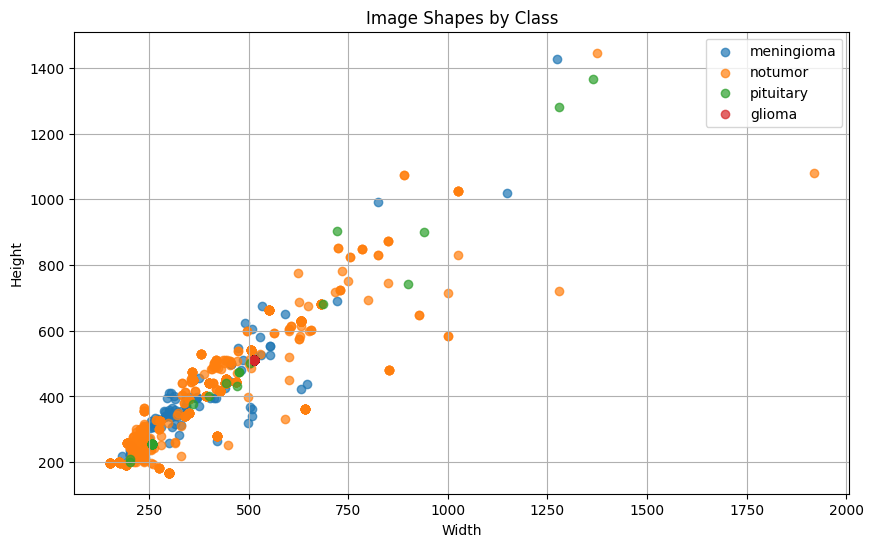

In [6]:
def plot_image_shape(df):
    shapes = df['Class Path'].apply(lambda x: mpimg.imread(x).shape)
    shapes_df = pd.DataFrame(shapes.tolist(), columns=['Height', 'Width', 'Channels'])
    shapes_df['Class'] = df['Class']

    plt.figure(figsize=(10, 6))
    for class_label in df['Class'].unique():
        class_shapes = shapes_df[shapes_df['Class'] == class_label]
        plt.scatter(class_shapes['Width'], class_shapes['Height'], label=class_label, alpha=0.7)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Shapes by Class')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_image_shape(tr_df)

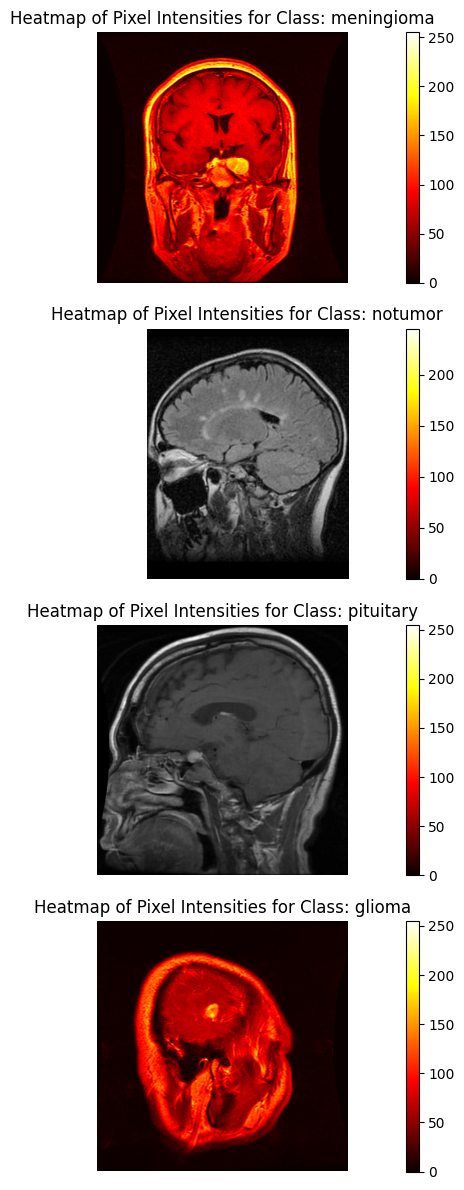

In [7]:
def plot_image_pixel_heatmap_per_class(df):
    classes = df['Class'].unique()

    plt.figure(figsize=(12, 12))

    for i, class_label in enumerate(classes):
        class_images = df[df['Class'] == class_label]['Class Path'].values
        img_path = random.choice(class_images)

        img = mpimg.imread(img_path)
        plt.subplot(len(classes), 1, i + 1)
        plt.imshow(img, cmap='hot')
        plt.colorbar()
        plt.title(f'Heatmap of Pixel Intensities for Class: {class_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_image_pixel_heatmap_per_class(tr_df)

/tmp/ipython-input-3303684817.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y='Class', palette='pastel')


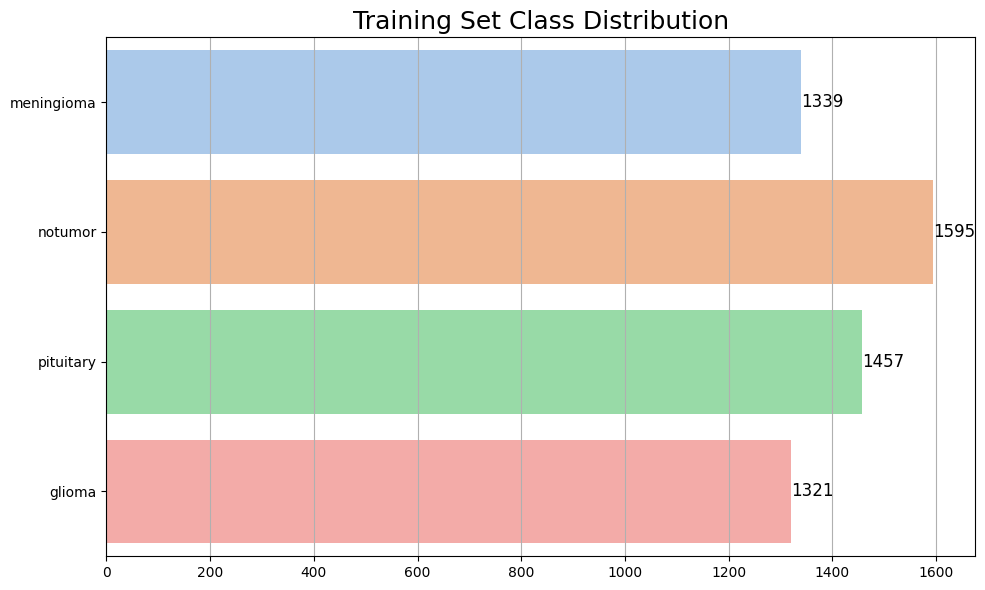

/tmp/ipython-input-3303684817.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y='Class', palette='pastel')


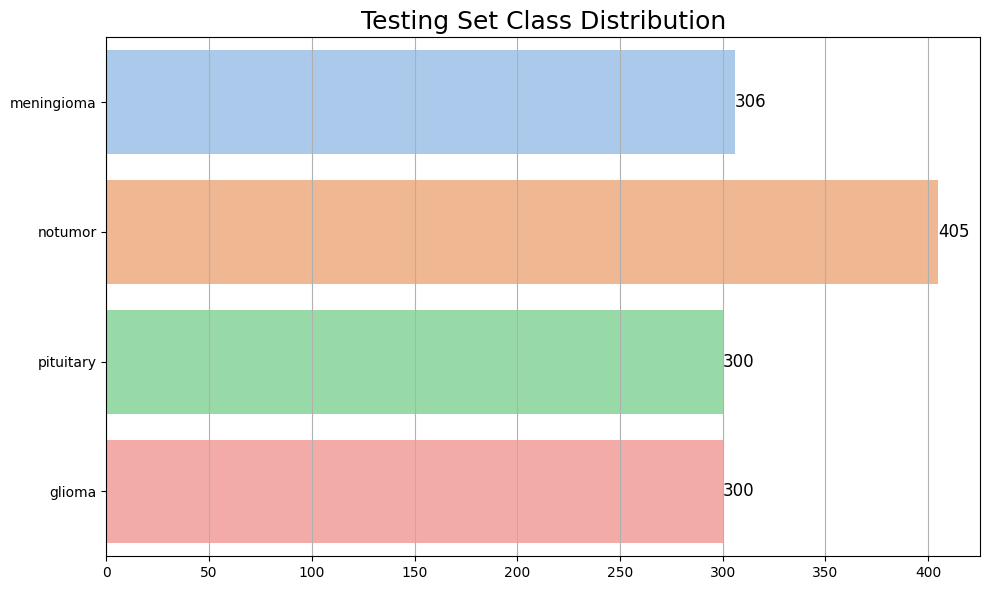

In [8]:
def plot_class_distribution(df, title):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, y='Class', palette='pastel')
    plt.title(title, fontsize=18)
    # Iterate over each container to add labels to all bars
    for container in ax.containers:
        ax.bar_label(container, fontsize=12)
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
plot_class_distribution(tr_df, "Training Set Class Distribution")
plot_class_distribution(ts_df, "Testing Set Class Distribution")

In [11]:
from sklearn.model_selection import train_test_split
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df['Class'], random_state=42)
img_size = (299, 299)
batch_size = 32

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug_gen = ImageDataGenerator(rescale=1./255, brightness_range=(0.8, 1.2))
test_gen = ImageDataGenerator(rescale=1./255)

tr_gen = aug_gen.flow_from_dataframe(tr_df, x_col='Class Path', y_col='Class',
                                     target_size=img_size, class_mode='categorical', batch_size=batch_size)

valid_gen = aug_gen.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class',
                                        target_size=img_size, class_mode='categorical', batch_size=batch_size)

ts_gen = test_gen.flow_from_dataframe(ts_df, x_col='Class Path', y_col='Class',
                                      target_size=img_size, class_mode='categorical', batch_size=16, shuffle=False)

class_dict = tr_gen.class_indices
classes = list(class_dict.keys())

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


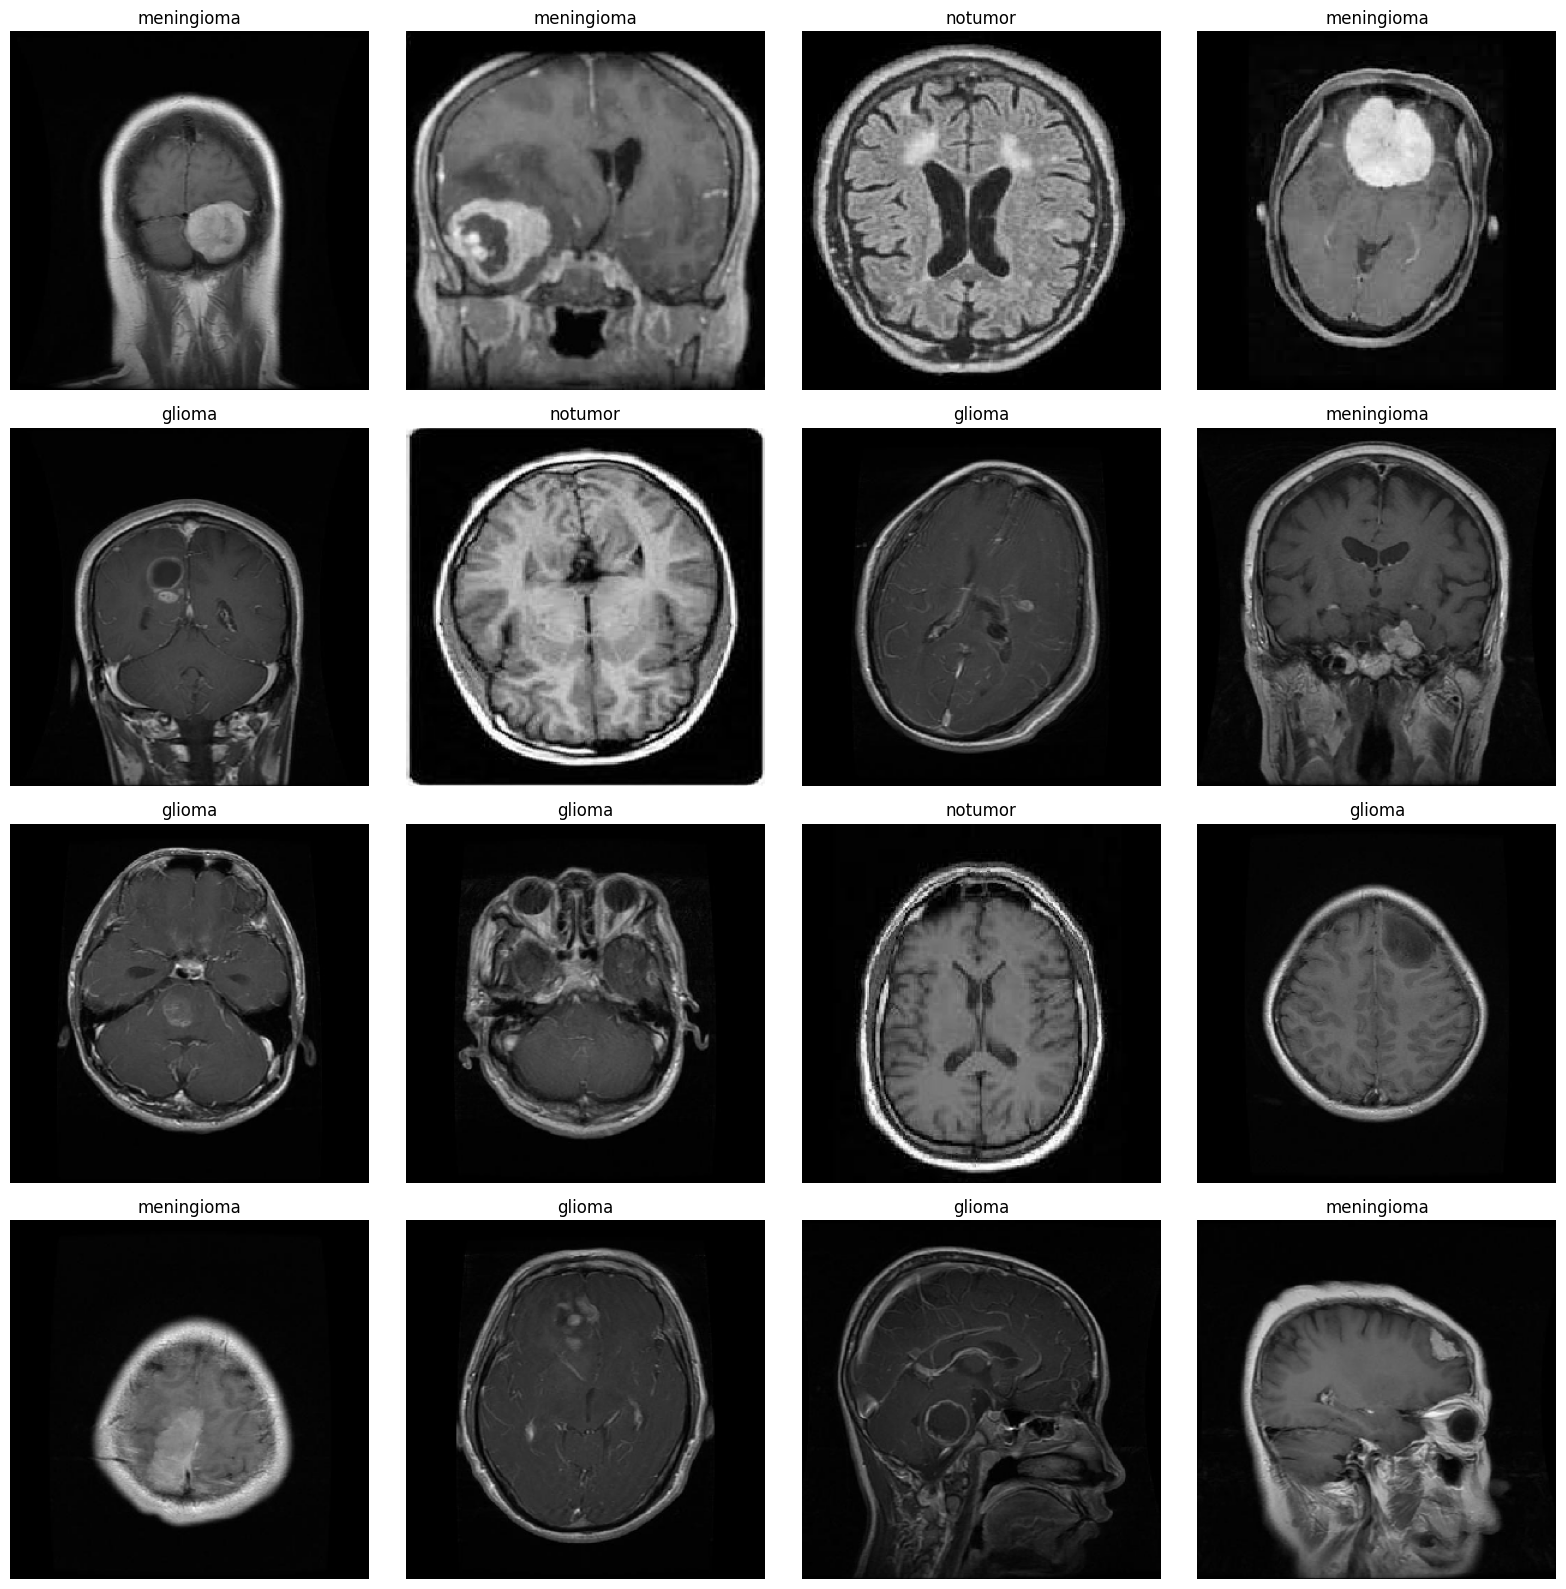

In [14]:
def show_sample_batch(generator):
    images, labels = next(generator)
    plt.figure(figsize=(16, 16))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.title(classes[np.argmax(labels[i])], fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_batch(ts_gen)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall

img_shape = (299, 299, 3)
base_model = tf.keras.applications.Xception(
    include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)
history = model.fit(tr_gen,
                    validation_data=valid_gen,
                    epochs=50,
                    shuffle=False,
                    callbacks=[early_stopping])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.6469 - loss: 1.0149 - precision: 0.7825 - recall: 0.4612 - val_accuracy: 0.9206 - val_loss: 0.1981 - val_precision: 0.9257 - val_recall: 0.9130
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 149s 834ms/step - accuracy: 0.9611 - loss: 0.0991 - precision: 0.9661 - recall: 0.9590 - val_accuracy: 0.9603 - val_loss: 0.1062 - val_precision: 0.9688 - val_recall: 0.9496
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 149s 832ms/step - accuracy: 0.9827 - loss: 0.0558 - precision: 0.9840 - recall: 0.9794 - val_accuracy: 0.9664 - val_loss: 0.1023 - val_precision: 0.9664 - val_recall: 0.9649
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 149s 833ms/step - accuracy: 0.9950 - loss: 0.0175 - precision: 0.9957 - recall: 0.9939 - val_accuracy: 0.9954 - val_loss: 0.0168 - val_precision: 0.9954 - val_recall: 0.9939
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 150s 835ms/step - accuracy: 0.9961 - loss: 0.0143 - precision: 0.9962 - recall: 0.9958 - val_accuracy: 0.99

In [19]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


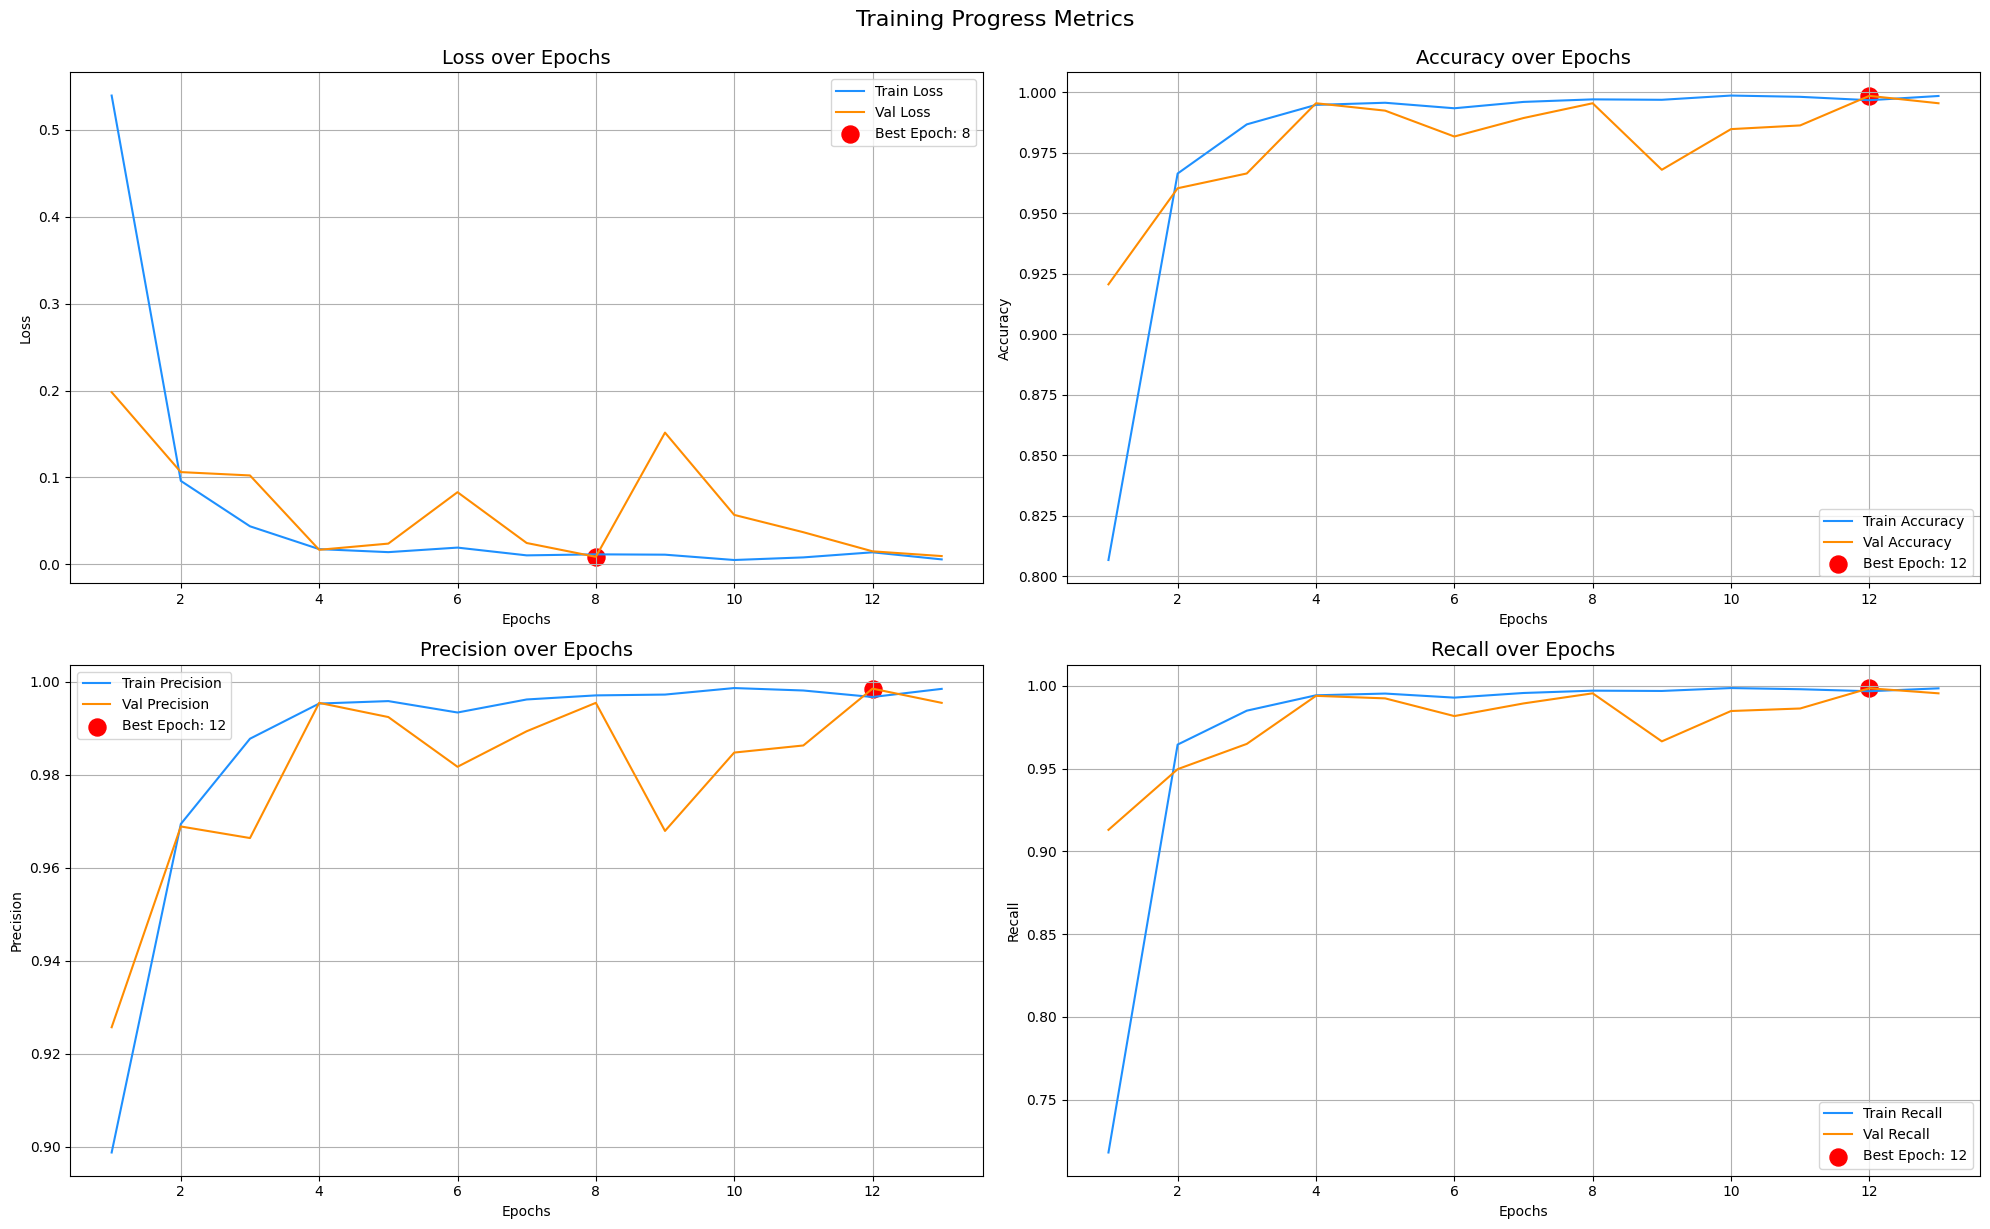

In [20]:
def plot_metrics(hist):
    metrics = {
        'loss': 'loss',
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall'
    }
    val_metrics = {
        k: f'val_{v}' for k, v in metrics.items()
    }
    epochs = range(1, len(hist.history['loss']) + 1)

    plt.figure(figsize=(20, 12))
    for i, (label, key) in enumerate(metrics.items()):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs, hist.history[key], label=f'Train {label.capitalize()}', color='dodgerblue')
        plt.plot(epochs, hist.history[val_metrics[label]], label=f'Val {label.capitalize()}', color='darkorange')
        best_epoch = (np.argmax(hist.history[val_metrics[label]]) + 1
                      if label != 'loss' else np.argmin(hist.history[val_metrics[label]]) + 1)
        best_value = (max(hist.history[val_metrics[label]])
                      if label != 'loss' else min(hist.history[val_metrics[label]]))
        plt.scatter(best_epoch, best_value, s=150, color='red', label=f'Best Epoch: {best_epoch}')
        plt.title(f"{label.capitalize()} over Epochs", fontsize=14)
        plt.xlabel('Epochs')
        plt.ylabel(label.capitalize())
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.suptitle("Training Progress Metrics", fontsize=16, y=1.02)
    plt.show()

plot_metrics(history)

In [21]:
train_score = model.evaluate(tr_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(ts_gen)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 303ms/step - accuracy: 0.9990 - loss: 0.0095 - precision: 0.9990 - recall: 0.9990
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.9973 - loss: 0.0051 - precision: 0.9973 - recall: 0.9973


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9816 - loss: 0.1261 - precision: 0.9816 - recall: 0.9816
Train Accuracy: 99.96%
Validation Accuracy: 99.69%
Test Accuracy: 98.78%


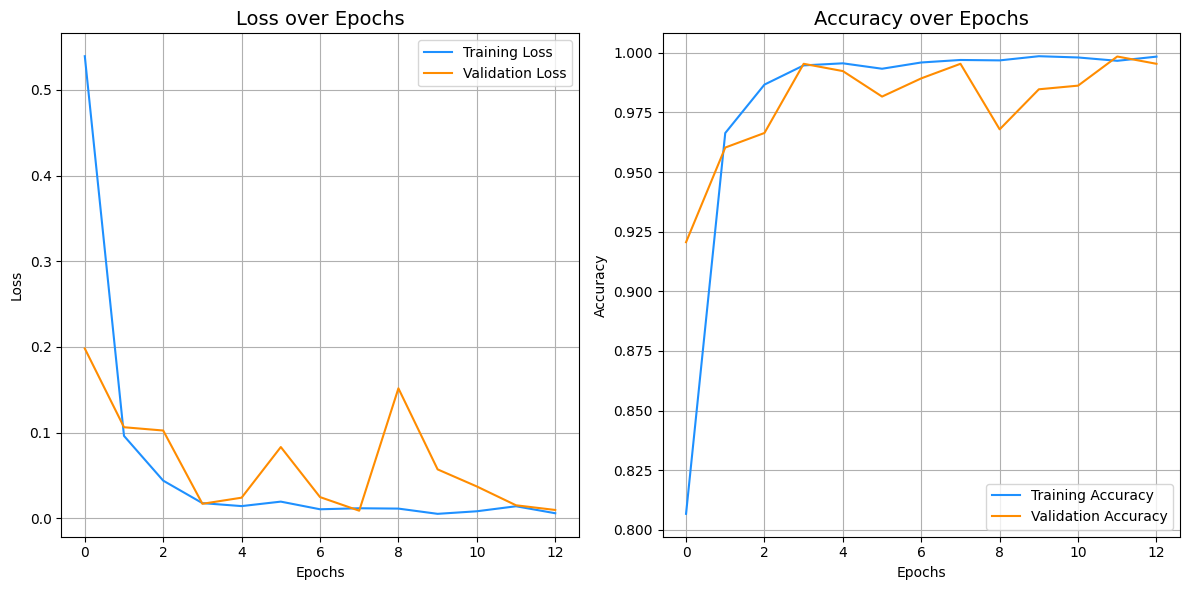

In [22]:
def plot_loss_accuracy(hist):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='Training Loss', color='dodgerblue')
    plt.plot(hist.history['val_loss'], label='Validation Loss', color='darkorange')
    plt.title('Loss over Epochs', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['accuracy'], label='Training Accuracy', color='dodgerblue')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
    plt.title('Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_accuracy(history)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step


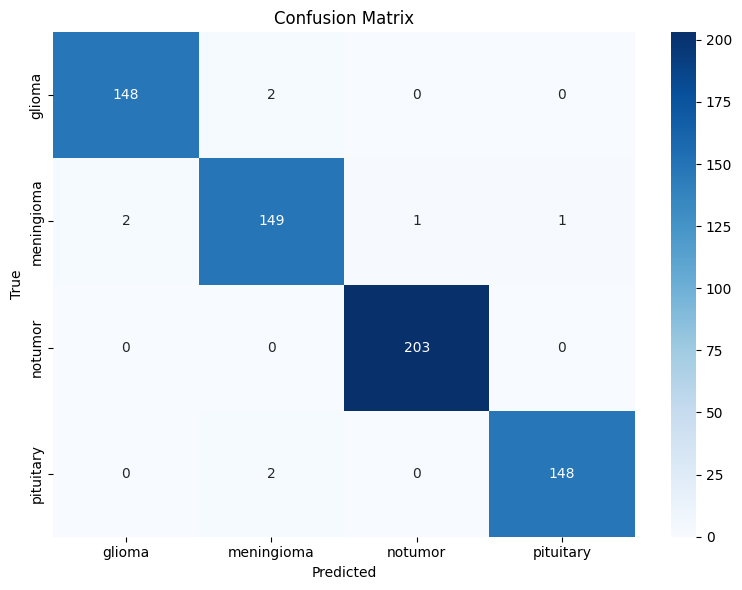

In [26]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model.predict(ts_gen), axis=1)
cm = confusion_matrix(ts_gen.classes, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [27]:
def predict(img_path):
    img = Image.open(img_path).resize(img_size)
    img_array = np.expand_dims(np.array(img) / 255., axis=0)
    pred = model.predict(img_array)[0]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    bars = plt.barh(classes, pred, color='teal')
    plt.title("Prediction Probabilities")
    plt.xlabel("Probability")
    plt.grid(True, axis='x')
    plt.gca().bar_label(bars, fmt='%.2f')
    plt.tight_layout()
    plt.show()

In [28]:
predict("/content/brain_tumor_dataset/Testing/glioma/Te-gl_0021.jpg")

NameError: name 'Image' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


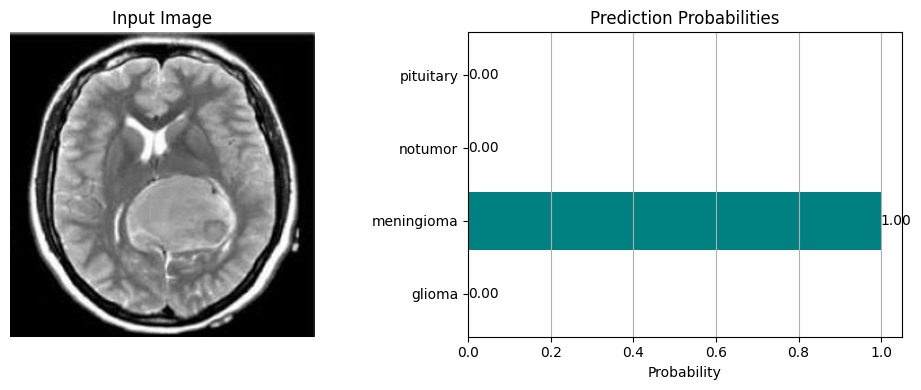

In [ ]:
predict("/content/brain_tumor_dataset/Testing/meningioma/Te-meTr_0006.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


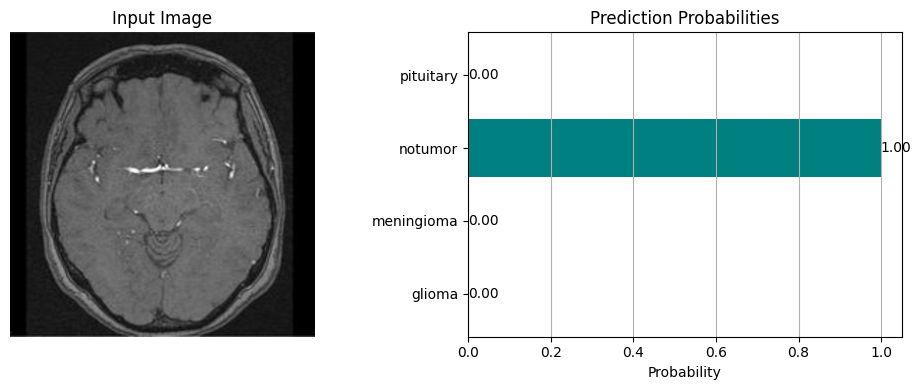

In [ ]:
predict("/content/brain_tumor_dataset/Testing/notumor/Te-no_0017.jpg")

In [29]:
model.save('/content/sample_data/enhanced_brain_tumor_classifier.h5')

In [30]:
model.save('/content/sample_data/Final_Model.keras')

In [35]:
from tensorflow.keras.models import load_model

# Load the old model without compiling
model = load_model("/content/sample_data/Final_Model.keras", compile=False)

# Export in TensorFlow SavedModel format
model.export("/content/sample_data/Final_Model_SavedModel")


Saved artifact at '/content/sample_data/Final_Model_SavedModel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137288528746000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137289348220304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137289348221072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137289348219920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137289348222224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137289348221456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137289348219728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137289348222032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137289348221840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137289348223184: TensorSpec(shape=(), dtype=tf.resource,

In [36]:
import shutil

# Zip the exported model folder
shutil.make_archive("/content/sample_data/Final_Model_SavedModel", 'zip', "/content/sample_data/Final_Model_SavedModel")


'/content/sample_data/Final_Model_SavedModel.zip'

In [37]:
from google.colab import files

files.download("/content/sample_data/Final_Model_SavedModel.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>